In [1]:
%load_ext autoreload
# %autoreload 2

# Our own model

### We decided to go with catboost as our black-box model as it is better fitted to categorical data such as this one, in which we have to predict whether an individual will default (1) or not (0).

In [2]:
import pandas as pd
from pathlib import Path

In [3]:
path = Path("../Data/dataproject2024.xlsx")
df = pd.read_excel(path)
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7430 non-null   int64  
 1   Job tenure            7430 non-null   int64  
 2   Age                   7430 non-null   int64  
 3   Car price             7430 non-null   int64  
 4   Funding amount        7430 non-null   int64  
 5   Down payment          7430 non-null   int64  
 6   Loan duration         7430 non-null   int64  
 7   Monthly payment       7430 non-null   float64
 8   Credit event          7430 non-null   int64  
 9   Married               7430 non-null   int64  
 10  Homeowner             7430 non-null   int64  
 11  Default (y)           7430 non-null   int64  
 12  Pred_default (y_hat)  7430 non-null   int64  
 13  PD                    7430 non-null   float64
 14  Group                 7430 non-null   int64  
dtypes: float64(2), int64(

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(["ID", "Default (y)", "Pred_default (y_hat)", "PD", "Group"], axis=1)
y = df["Default (y)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function="Logloss", verbose=False)
cat_model.fit(X_train, y_train)

In [6]:
y_pred_class = cat_model.predict(X_test)
y_pred_prob = cat_model.predict_proba(X_test)[:,1]

In [7]:
df_pred = pd.DataFrame([y_pred_class, y_pred_prob]).transpose()
df_pred = df_pred.rename(columns={0: "y_hat", 1:"prob_default"})
df_pred = df_pred.astype({"y_hat": int})
df_pred

,y_hat,prob_default
0,0,0.398001
1,0,0.321803
2,0,0.337837
3,0,0.465416
4,0,0.204981
...,...,...
1110,0,0.233575
1111,0,0.274995
1112,0,0.301350
1113,0,0.350021


In [8]:
from sklearn.metrics import accuracy_score

acc_cat = accuracy_score(df_pred["y_hat"], y_test)
acc_init_model = accuracy_score(df["Default (y)"], df["Pred_default (y_hat)"])

print(f'The accuracy with a CatboostClassifier model is {acc_cat: .3f}, whereas the accuracy of the initial model was {acc_init_model: .3f}.')

The accuracy with a CatboostClassifier model is  0.830, whereas the accuracy of the initial model was  0.847.


In [9]:
cat_model.save_model("../assets/cat_boost_model")

### Saving the predictions for the whole dataframe to build surrogates model for it

In [10]:
y_pred_prob_total = cat_model.predict_proba(X)[:,1]
y_pred_class_total = cat_model.predict(X)
df_pred_total = pd.DataFrame([y_pred_class_total, y_pred_prob_total]).transpose()
df_pred_total = df_pred_total.rename(columns={0: "y_hat", 1:"pred_default"})
df_pred_total = df_pred_total.astype({"y_hat": int})
df_pred_total

,y_hat,pred_default
0,0,0.133421
1,0,0.281574
2,0,0.201414
3,0,0.172394
4,0,0.327764
...,...,...
7425,0,0.410737
7426,0,0.330510
7427,0,0.387032
7428,0,0.233245


In [11]:
df_total = pd.concat([X, df_pred_total], axis=1)
df_total

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,y_hat,pred_default
0,34,55,4875,3087,0,36,0.047895,0,1,1,0,0.133421
1,5,29,13000,13000,0,60,0.091667,0,0,0,0,0.281574
2,14,38,17190,14190,0,60,0.088235,0,0,0,0,0.201414
3,16,37,22773,23568,0,48,0.110084,0,1,1,0,0.172394
4,1,61,7700,8526,0,48,0.123404,0,1,0,0,0.327764
...,...,...,...,...,...,...,...,...,...,...,...,...
7425,9,38,4502,4856,0,48,0.083846,1,0,0,0,0.410737
7426,1,33,22900,17900,0,60,0.098000,0,0,0,0,0.330510
7427,3,27,25858,25972,0,24,0.181667,0,0,0,0,0.387032
7428,6,32,12300,11300,0,72,0.091963,0,0,1,0,0.233245


In [12]:
df_total.to_csv("../Data/catboost_output.csv")

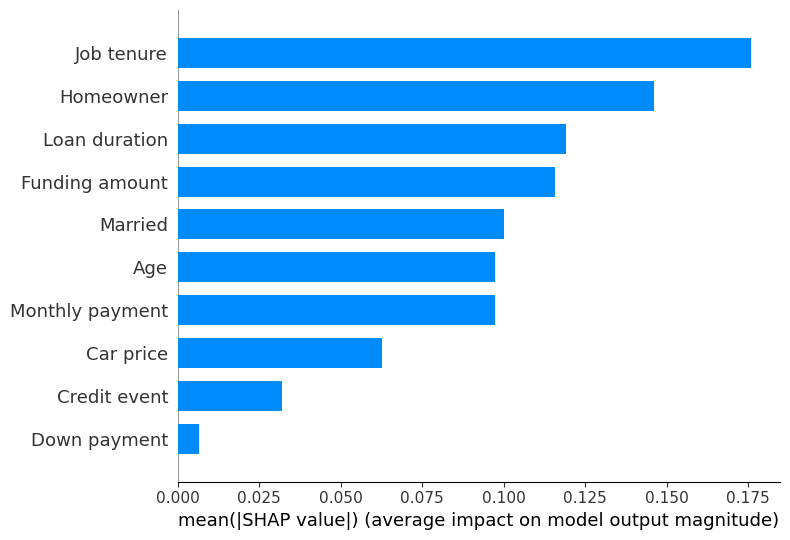

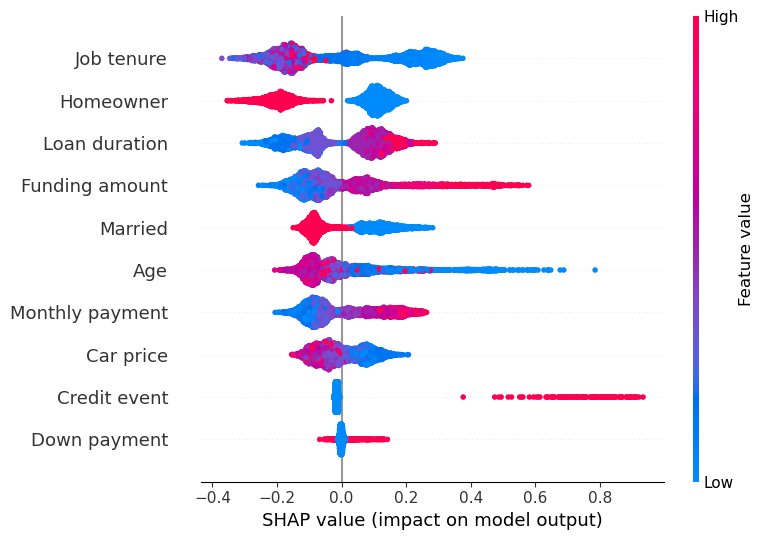

In [13]:
import sys
sys.path.append("..")

from src.shap import draw_shap_summary, draw_shap_tree
draw_shap_summary(model=cat_model, data=X_train, model_name="cat_model")
draw_shap_tree(model=cat_model, data=X_train, model_name="cat_model")

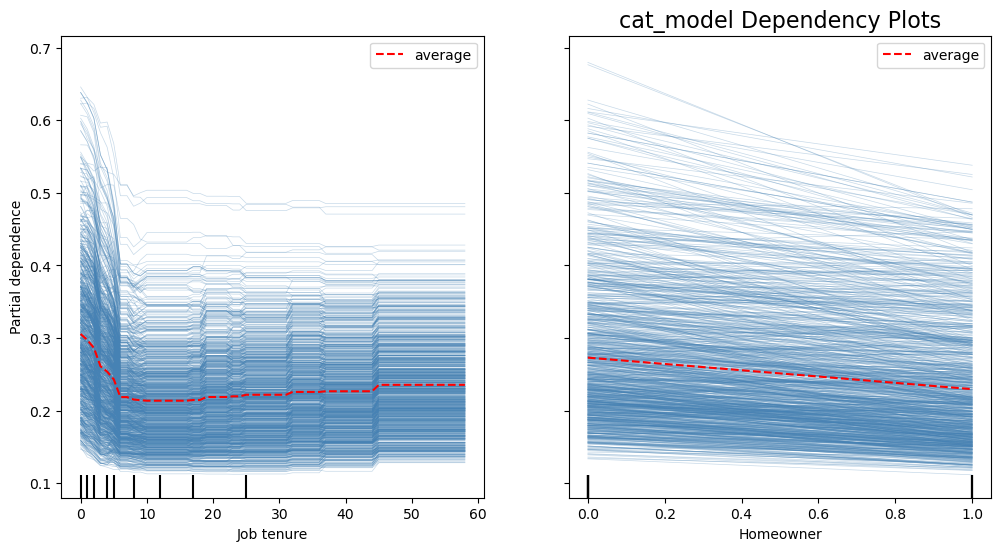

In [14]:
from src.pdp_ice import draw_pdp_ice_graphs
draw_pdp_ice_graphs(model=cat_model, data=X_train, model_name="cat_model", variables=["Job tenure", "Homeowner"])

Performance Metrics:  0.8


Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

1022


Performing Computation: 100%|██████████| 1/1 [00:58<00:00, 58.52s/it]


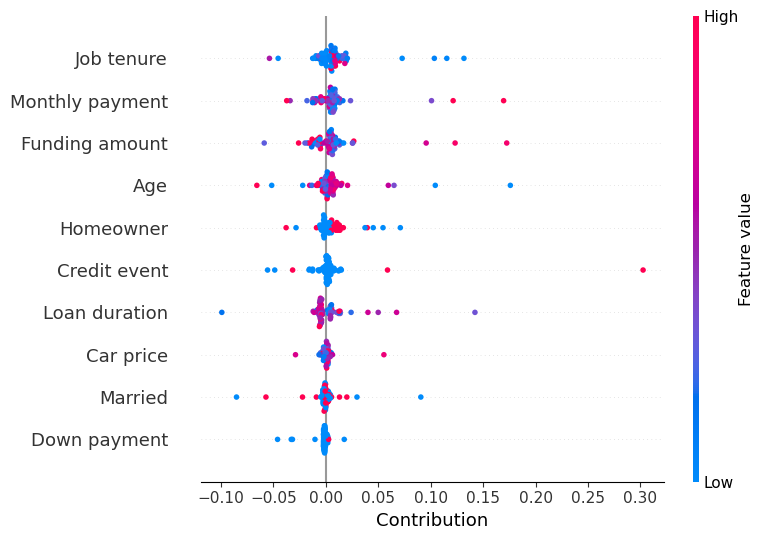

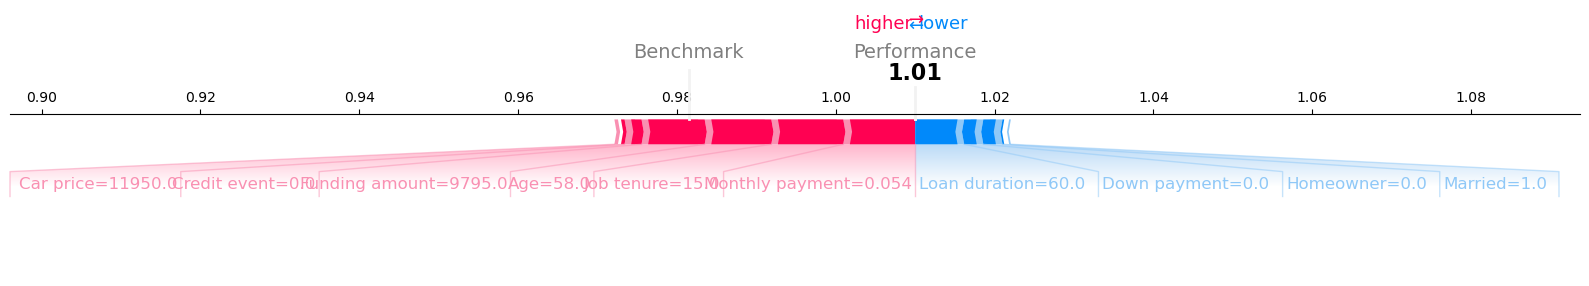

Metric: r2
    Funding amount 0.093 +/- 0.021
    Age      0.091 +/- 0.022
    Loan duration 0.065 +/- 0.025
    Monthly payment 0.062 +/- 0.022
    Car price 0.061 +/- 0.017
    Job tenure 0.061 +/- 0.029
    Homeowner 0.054 +/- 0.024


In [15]:
from src.part8 import xper_method, perm_imp

df2 = df.sample(500).drop(["ID", "Pred_default (y_hat)", "PD", "Group"], axis=1)
X_filtered = df2.drop("Default (y)", axis=1)
y_filtered = df2["Default (y)"]
 
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered, y_filtered, test_size=0.15, random_state=42)

xper_method(model=cat_model, eval_metric="Accuracy", dataset=df2, target_col="Default (y)", X_train=X_train_filt, y_train=y_train_filt, X_test=X_test_filt, y_test=y_test_filt)
perm_imp(scoring=['r2'], model=cat_model, X_train=X_train_filt, y_train=y_train_filt)

In [16]:
from src.statistical_parity_test import test_statistical_parity, calculate_p_values, draw_fpdp

test_statistical_parity(df["Group"], df_total["y_hat"])

0.0

In [17]:
calculate_p_values(df["Group"], df_total["pred_default"], [0.3, 0.5, 0.7])

array([0., 0., 1.])

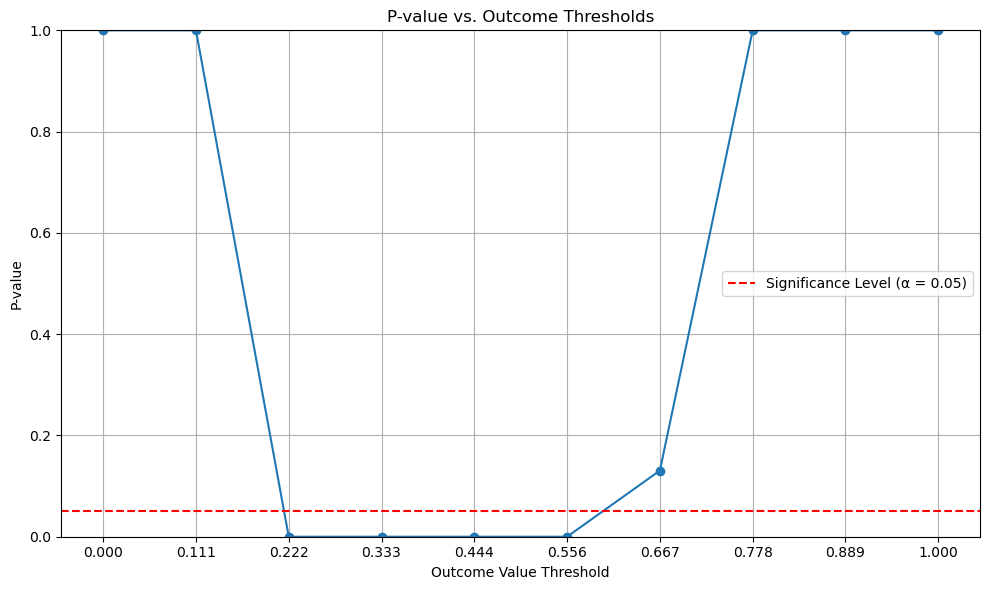

In [18]:
draw_fpdp(df["Group"], df_total["pred_default"])

In [29]:
from src.cond_stat_parity import conditional_statistical_parity_test

df_cond_stat_parity = conditional_statistical_parity_test(df=df_total, outcome_col="y_hat", protected_attr="Age", conditioned_attr="Funding amount")
df_cond_stat_parity

,Condition,Protected_Group,Positive_Outcome_Rate,Total_Samples
0,546,24,0.0,1
1,715,52,0.0,1
2,923,34,0.0,1
3,1025,50,0.0,1
4,1501,41,0.0,1
...,...,...,...,...
7275,30000,49,0.0,1
7276,30000,56,0.0,1
7277,30000,62,0.0,1
7278,30000,64,0.0,1


In [30]:
def age_group(row):
    if row["Protected_Group"] <= 30:
        return "Young adult"
    elif 30 < row["Protected_Group"] <= 50:
        return "Experienced adult"
    elif 50 < row["Protected_Group"] <= 70:
        return "Senior"
    return "Elderly"
    
df_cond_stat_parity["Age group"] = df_cond_stat_parity.apply(age_group, axis=1)
df_cond_stat_parity

,Condition,Protected_Group,Positive_Outcome_Rate,Total_Samples,Age group
0,546,24,0.0,1,Young adult
1,715,52,0.0,1,Senior
2,923,34,0.0,1,Experienced adult
3,1025,50,0.0,1,Experienced adult
4,1501,41,0.0,1,Experienced adult
...,...,...,...,...,...
7275,30000,49,0.0,1,Experienced adult
7276,30000,56,0.0,1,Senior
7277,30000,62,0.0,1,Senior
7278,30000,64,0.0,1,Senior


In [31]:
avg_by_age = df_cond_stat_parity.groupby("Age group").mean("Positive_Outcome_Rate")
avg_by_age

,Condition,Protected_Group,Positive_Outcome_Rate,Total_Samples
Age group,,,,
Elderly,9101.317416,75.873596,0.000000,1.014045
Experienced adult,11894.112714,41.301912,0.015431,1.020463
Senior,10673.389733,57.974949,0.003285,1.024230
Young adult,12557.346154,24.822944,0.124668,1.016578


We clearly identify a bias for young adults, as the mean of their group age default rate for a loan is way higher than that of other age groups.